## Introduction and Motivation


Studies of the large-scale structure of the Universe provide insight into the conditions of the early universe, the nature of dark matter and dark energy, and galaxy evolution. 
One of the most important statistical tools that cosmologists use to understand large-scale structure is the galaxy power spectrum, P(k),which quanitfies the clustering of galaxies as a function of spatial scale. 
By analyzing the shape and features of the galaxy power spectrum, cosmologists can trace the growth of structure across cosmic time and constrain key cosmological parameters. 

### Calculating P(k)
P(k) is the Fourier transform of the two-point correlation function, $\xi(r)$. 

$\xi(r)$ measures the clumpiness of galaxies by quantifying the excess probability of finding a pair of galaxies separated by a distace r, compared to a random, uniform distribution. 
\begin{align}
P(k)= \int{\xi(r)e^{i\boldsymbol{k}\cdot\boldsymbol{r}} d^3\boldsymbol{r}}
\end{align}

For our project, we will create a mock galaxy catalog and compare the accuracy and computational efficiency of different methods of calculating P(k).

## Creating a Mock Catalog

We use the Python package nbodykit to generate a log-normal mock catalog at z=0.55 with galaxy bias b=2 in a box of side-length 1380 Mpc/h. Our mock catalog contains ~8 million galaxies.

Log-normal mocks assume that the matter density field follows a log-normal distribution. This ensures that the densities remain positive and mimic the midly non-linear clustering of galaxies. Galaxies are then sampled from this distribution following an input power spectrum. This will serve as our true power spectrum that we can compare our P(k) estimators to.

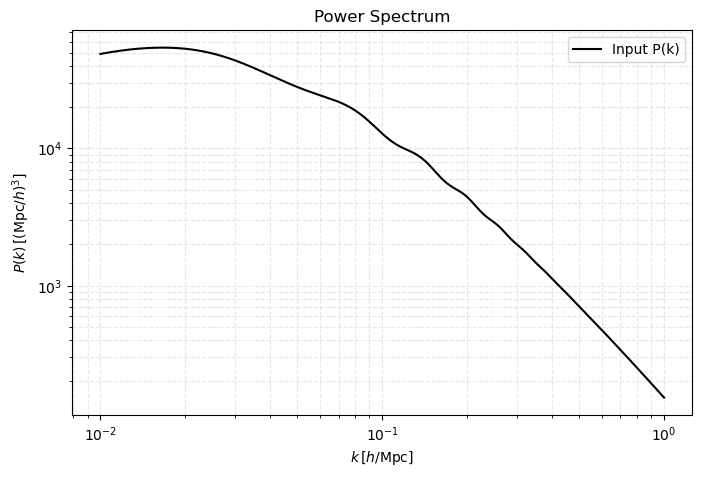

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Plot real P(k) from nbodykit
truth = np.loadtxt("data/power_spectrum.txt", skiprows=1)
k_true = truth[:, 0]
P_true = truth[:, 1]

plt.figure(figsize=[8,5])
plt.loglog(k_true, P_true, color='k', label='Input P(k)')

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \, [( \mathrm{Mpc}/h)^3 ]$')
plt.title('Power Spectrum')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)

### What can we learn from this power spectrum? 

Let's start with the x-axis. Small k values correspond to large physical scales (hundreds of Mpc) and large k values correspond to small scales. 

We immediately notice that the clustering amplitude is largest at large-scales and decreases as we move to smaller scales. There is a turnover point after which the power spectrum begins decreasing steeply, the location of this turnover point encodes information about the epoch of matter-radiation equality. 

There are also some small wiggles around k ~ 0.06-0.3. These are the Baryon Acoustic Oscillations (BAO) caused by acoustic density waves in the photon-baryon plasma of the early universe.

## How can we measure the power spectrum from our mock catalog? 

1. Pair-counting Method + Hankel Transform
2. Taking the Fourier transform of the galaxy overdensity field

## Method 1: Pair-counting Method + Hankel Transform

The following describes the henkel_pk.py script which performs a two-step cosmological analysis pipeline:

1. It computes the two-point correlation function ξ(r) from a mock galaxy catalog using the Corrfunc library

2. It then transforms ξ(r) into the power spectrum P(k) via a numerical Hankel transform

Together, these two quantities describe the spatial clustering of matter in both configuration (ξ) and Fourier (P) space.

### Step 1: Computing ξ(r)

The `henkel_pk.py` script defines a class `CorrfuncCalculator` that loads our mock galaxy catalog. The script allows the user to randomly downsample the data for faster computation. It creates a random catalog of uniformly distributed points within the same simulation box which is used for normalization. We define logarithmic separation bins between user-specified rmin and rmax.

The class takes user-input for:
* the fraction of the sample to be used (ex: sample_frac=0.5 means 50% of dataset will be used)
* the boxsize used to generate the mocks
* the number of separation (r) bins
* mininum separation (Mpc/h)
* maximum separation (Mpc/h)
* number of threads for parallel computing
* random number seed to build the randoms

```python
# This is code displayed for reference only, executable code lies within src/henkel_pk.py
class CorrfuncCalculator:
    def __init__(self, datafile, sample_frac=0.01, boxsize=1380.0, nbins=20, rmin=0.1, rmax=300, nthreads=8, seed=42):
        """
        Compute the two-point correlation function using Corrfunc.

        Parameters
        ----------
        datafile : str
            Path to .npz mock catalog (expects 'pos' and 'weight' arrays)
        sample_frac : float
            Fraction of data points to randomly sample (0 < sample_frac <= 1)
        boxsize : float
            Box size in Mpc/h
        nbins : int
            Number of logarithmic separation bins
        rmin, rmax : float
            Minimum and maximum separations in Mpc/h
        nthreads : int
            Number of CPU threads for Corrfunc
        seed : int
            Random seed for reproducibility
        """
        self.datafile = datafile
        self.sample_frac = sample_frac
        self.boxsize = boxsize
        self.nbins = nbins
        self.rmin = rmin
        self.rmax = rmax
        self.nthreads = nthreads
        self.seed = seed

        # Load data and prepare coordinates
        self._load_data()

        # Define bins
        self.bins = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1)

    def _load_data(self):
        np.random.seed(self.seed)
        data = np.load(self.datafile)
        pos = np.float64(data['pos'])
        N_total = len(pos)
        N_sample = int(N_total * self.sample_frac)
        print(f"Sampling {N_sample}/{N_total} points ({self.sample_frac*100:.1f}%)")

        idx = np.random.choice(N_total, size=N_sample, replace=False)
        self.x, self.y, self.z = pos[idx, 0], pos[idx, 1], pos[idx, 2]
        self.N = N_sample

        # Generate random catalog (3x number of data points)
        self.rand_N = 3 * self.N
        self.rand_X = np.random.uniform(0, self.boxsize, self.rand_N)
        self.rand_Y = np.random.uniform(0, self.boxsize, self.rand_N)
        self.rand_Z = np.random.uniform(0, self.boxsize, self.rand_N)



The class uses the `Corrfunc` library’s `DD` function to efficiently count pairs of points separated by different distances:

* DD: galaxy–galaxy pairs

* DR: galaxy–random pairs

* RR: random–random pairs

These counts are combined with Corrfunc’s `convert_3d_counts_to_cf` utility to compute ξ(r) using the Landy-Szalay estimator:

$$
\xi(r) = \frac{DD - 2DR + RR}{RR}
$$

which measures excess clustering relative to a uniform distribution. The class also estimates simple Poisson errors and saves results r, ξ(r), and Poisson error.

```python
# This is code displayed for reference only, executable code lies within src/henkel_pk.py
    def compute_xi(self):
        """Compute DD, DR, RR, and correlation function ξ(r)."""
        print("Computing DD, DR, RR with Corrfunc...")

        # DD
        start = time.time()
        DD_counts = DD(autocorr=1, nthreads=self.nthreads, binfile=self.bins,
                       X1=self.x, Y1=self.y, Z1=self.z, boxsize=self.boxsize)
        print(f"DD done in {time.time() - start:.2f} s")

        # DR
        start = time.time()
        DR_counts = DD(autocorr=0, nthreads=self.nthreads, binfile=self.bins,
                       X1=self.x, Y1=self.y, Z1=self.z,
                       X2=self.rand_X, Y2=self.rand_Y, Z2=self.rand_Z, boxsize=self.boxsize)
        print(f"DR done in {time.time() - start:.2f} s")

        # RR
        start = time.time()
        RR_counts = DD(autocorr=1, nthreads=self.nthreads, binfile=self.bins,
                       X1=self.rand_X, Y1=self.rand_Y, Z1=self.rand_Z, boxsize=self.boxsize)
        print(f"RR done in {time.time() - start:.2f} s")

        # Correlation function
        self.cf = convert_3d_counts_to_cf(self.N, self.N, self.rand_N, self.rand_N,
                                          DD_counts, DR_counts, DR_counts, RR_counts)
        self.r_centers = np.sqrt(self.bins[:-1] * self.bins[1:])

        dd = np.maximum(DD_counts['npairs'], 1.0)

        #simple Poisson estimate
        self.cf_err = (1.0 + self.cf) / np.sqrt(dd)

        #if any NaNs or infinities, replace with large finite numbers
        self.cf_err = np.nan_to_num(self.cf_err, nan=1e6, posinf=1e6, neginf=1e6)

        #return self.r_centers, self.cf, self.cf_err
        return self.r_centers, self.cf, self.cf_err

    def save_xi(self, filename=None):
        if filename is None:
            filename = f"data/xi_{self.sample_frac}.txt"
        np.savetxt(filename, np.column_stack([self.r_centers, self.cf, self.cf_err]),
                header="r [Mpc/h]   xi(r)     xi_err(r)")
        print(f"Saved results to {filename}")

    def plot_xi(self, outfile=None):
        if outfile is None:
            outfile = f"data/xi_plot_{self.sample_frac}.png"
        plt.figure(figsize=(6, 4))
        #plt.loglog(self.r_centers, self.cf, marker='o', linestyle='-', color='b')
        plt.errorbar(self.r_centers, self.cf, yerr=self.cf_err, fmt='o-', capsize=4, color='b', label='P(k)')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r"$r\,[{\rm Mpc}/h]$")
        plt.ylabel(r"$\xi(r)$")
        plt.xlim(self.rmin, self.rmax)
        plt.grid(True, which='both', ls='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(outfile, dpi=300)
        plt.show()
        print(f"Saved plot to {outfile}")

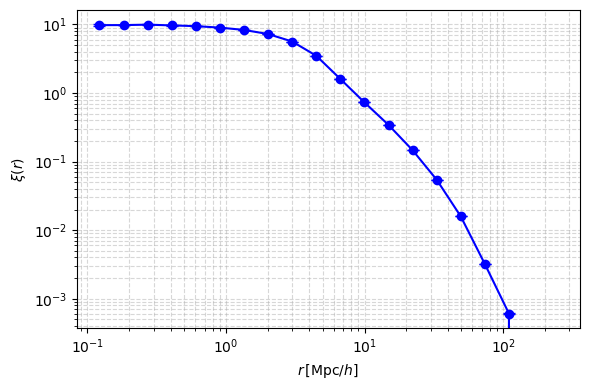

In [13]:
#Plot of 2pt correlation function using 100% of dataset
r_centers, cf, cf_err = np.loadtxt("data/xi_1.txt", skiprows=1, unpack=True)
plt.figure(figsize=(6, 4))
plt.errorbar(r_centers, cf, yerr=cf_err, fmt='o-', capsize=4, color='b', label='P(k)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$r\,[{\rm Mpc}/h]$")
plt.ylabel(r"$\xi(r)$")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Step 2: Computing Hankel Transform
The second class in `henkel_pk.py`, `HenkelTransform`, takes the saved correlation function and performs a numerical Hankel transform to obtain P(k) *without performing a Fast Fourier Transform*. In theory, $\xi(r)$ and $P(k)$ are exact Fourier transform pairs for a statistically isotropic universe:

$$
\xi(r) = \frac{1}{2\pi^2} \int_0^{\infty} k^2 P(k) \frac{\sin(kr)}{kr} \, dk
$$

$$
P(k) = 4\pi \int_0^{\infty} r^2 \xi(r) \frac{\sin(kr)}{kr} \, dr
$$

However, in practice the integral must be approximated because
1. ξ(r) is only known over a finite range of r,
2. it is discretely sampled, and
3. edge effects can distort the transform.

To mitigate these issues, the script applies a tapering window function

$$
W(r) = \exp\Big[-(r/300)^4\Big]
$$

before integrating with the trapezoidal rule (np.trapz). This produces an approximate estimate of P(k), with errors derived from sample variance and shot noise


```python
# This is code displayed for reference only, executable code lies within src/henkel_pk.py
class HenkelTransform:
    def __init__(self, datafile, sample_frac=0.01, boxsize=1380.0, nbar=3e-3):
        """
        Compute the galaxy power spectrum using the Henkel Transformation

        Parameters
        ----------
        datafile : str
            Path to 2pt correlation file
        sample_frac : float
            Fraction of data points to randomly sample (0 < sample_frac <= 1)
        boxsize : float
            Box size in Mpc/h
        nbar : float
            Number density of mock catalog in [h/Mpc]^3
        """
        self.datafile = datafile
        self.boxsize = boxsize
        self.nbar = nbar

        # Load data and prepare coordinates
        r, xi, xi_err = np.loadtxt(datafile, unpack=True)
        k = np.logspace(-2, 1, 200)

        self.r = r
        self.xi = xi
        self.k = k
        self.sample_frac = sample_frac

    def compute_pk(self):
        """Compute power spectrum"""
        print("Computing power spectrum from Hankel Transformation")

        Pk = np.zeros_like(self.k)

        W = np.exp(- (self.r / 300)**4) #300 Mpc/h is rmax
        xi_tapered = self.xi * W

        for i, kk in enumerate(self.k):
            integrand = self.r**2 * xi_tapered * np.sinc(kk * self.r / np.pi)
            Pk[i] = 4 * np.pi * np.trapz(integrand, self.r)

        self.Pk = Pk

        V = self.boxsize**3
        dk = np.gradient(self.k)
        Nm = V * 4 * np.pi * self.k**2 * dk / (2 * np.pi)**3
        sigma_Pk = np.sqrt(2 / Nm) * (Pk + 1.0 / self.nbar)

        self.sigma_Pk = sigma_Pk


        return self.k, self.Pk, self.sigma_Pk


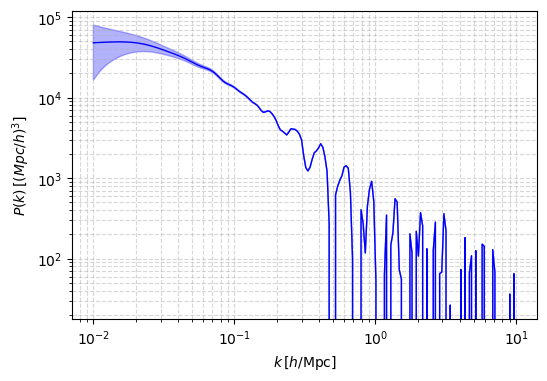

In [14]:
k, Pk, sigma_Pk = np.loadtxt("data/pk_from_xi_1.txt", skiprows=1, unpack=True)
plt.figure(figsize=(6,4))
plt.loglog(k, Pk, color = 'b', lw=1)
plt.fill_between(k, Pk - sigma_Pk, Pk + sigma_Pk, color='b', alpha=0.3)
plt.xlabel(r"$k\,[h/{\rm Mpc}]$")
plt.ylabel(r"$P(k)\,[(Mpc/h)^3]$")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()  

## Method 2: Taking the Fourier Transform of the galaxy overdensity field

We begin by assigning our mock galaxies to a 3D grid so that we can FFT the field. 

We use the Cloud-in-Cell mass assignment scheme to find the total density at each grid point. In 3D, each particle contributes to the 8 neighboring grid points. The weight assigned to each point is a function of the particle's 3D position. Then density field cnan then be computed by adding up all the density contributions from all the galaxies at each grid point

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Load in mock catalog 
data = np.load("data/mock_catalog.npz")
positions = data['pos']

# Assign mock particles to a grid
def cic_grid(positions, Ngrid, boxsize):
    # Create a 3d grid
    density = np.zeros((Ngrid, Ngrid, Ngrid), dtype=np.float32)
    # Convert physical coordinates to grid coordinates
    cell = positions / (boxsize / Ngrid)
    # Find index of the grid cell for each particle 
    i = np.floor(cell).astype(int) % Ngrid # %Ngrid wraps positions that land outside the box 
    # How far the particle is from the grid points in all 3 dimensions
    d = cell - i

    # Distribute weights using Cloud-in-Cell
    # For CIC we assign weights to the 8 neighboring grid cells using the particle's 3D position
    for dx in (0,1):
        # Weight is 1 - offset for the lower axis point and weight equals offset for the upper axis point
        if dx == 0: 
            wx = (1 - d[:,0]) 
        else: 
            wx = d[:,0]
        for dy in (0,1):
            if dy == 0: 
                wy = (1 - d[:,1])
            else: 
                wy = d[:, 1]
            for dz in (0,1):
                if dz == 0:
                    wz = (1 - d[:,2]) 
                else: 
                    wz = d[:, 2]
                ii = (i[:,0] + dx) % Ngrid
                jj = (i[:,1] + dy) % Ngrid
                kk = (i[:,2] + dz) % Ngrid
                w = wx * wy * wz
                # Add the weights for each grid cell
                np.add.at(density, (ii, jj, kk), w)
    # Return the density of particles for each grid cell
    return density

In [16]:
# Set parameters
Ngrid = 256
boxsize = 1380  # Mpc/h

# Calculate the density grid
rho = cic_grid(positions, Ngrid, boxsize)

Once we have the density field, we can calculate the fractional overdensity field. 
\begin{align}
\delta (x) = \frac{\rho - \bar{\rho}}{\bar{\rho}}
\end{align}
We then take the Fourier Transform
\begin{align}
\tilde{\delta}(k) = \int{\delta(x)e^{i\boldsymbol{k}\cdot\boldsymbol{x}}d^3x}
\end{align}
and the Power Spectrum is given by the squared Fourier amplitudes
\begin{align}
P(k) = \langle |\tilde{\delta}(k)|^2 \rangle
\end{align}

In [17]:
# Compute overdensity field
delta = (rho - rho.mean()) / rho.mean()

from numpy.fft import fftn
# Take the FFT of the overdensity field
delta_k = fftn(delta)
power_k = np.abs(delta_k)**2  # complex modulus squared

# Bin P(k) in spherical shells
# Compute k-grid
kx = np.fft.fftfreq(Ngrid, d=boxsize/Ngrid) * 2*np.pi # Mutliply by 2pi to convert to wavenumbers
# Grid is the same for all 3 axes
ky = kx
kz = kx
kx,ky,kz = np.meshgrid(kx,ky,kz, indexing='ij')
# Compute the magnitude
kk = np.sqrt(kx**2 + ky**2 + kz**2)

# Create 50 k bins
k_bins = np.linspace(0, kk.max(), 50)
Pk = np.zeros(len(k_bins)-1)

for i in range(len(k_bins)-1):
    # Find the bin index for the k value
    idx = (kk>=k_bins[i]) & (kk<k_bins[i+1])
    # Take the average power within each k shell
    Pk[i] = power_k[idx].mean() * (boxsize**3 / Ngrid**6)  # normalization

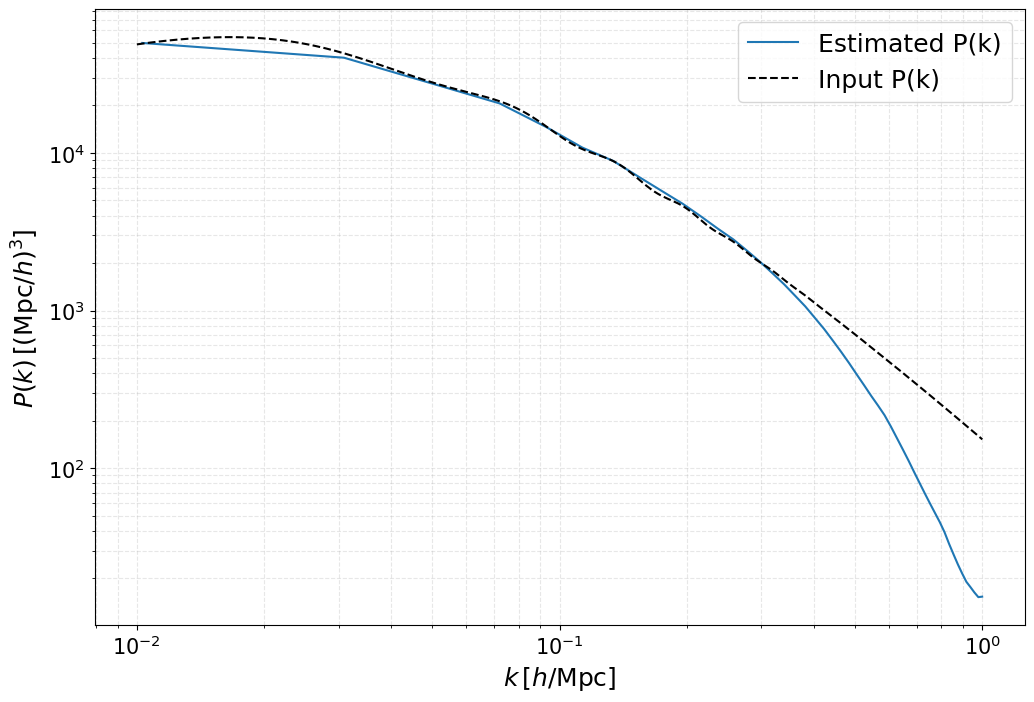

In [18]:
# Compute bin centers
k_mid = 0.5 * (k_bins[1:] + k_bins[:-1])

# Plot log-log power spectrum
plt.figure(figsize=(12,8))
plt.loglog(k_mid, Pk, label='Estimated P(k)')

# Compare to real P(k) from nbodykit
real = np.loadtxt("data/power_spectrum.txt", skiprows=1)
k_theory = real[:, 0]
P_theory = real[:, 1]

plt.loglog(k_theory, P_theory, color='k', linestyle='--', label='Input P(k)')

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$', fontsize=18)
plt.ylabel(r'$P(k) \, [( \mathrm{Mpc}/h)^3 ]$', fontsize=18)
plt.tick_params(axis='x', labelsize=15) 
plt.tick_params(axis='y', labelsize=15) 
plt.legend(fontsize=18)
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.show()

## Results and Error Analysis

First, we present our results from both methods of calculating the power spectra. 

We created five total mock catalogs for this project, all using the same true power spectrum. Due to the computationally expensive nature of the Hankel Transform method, we only compute the power spectrum for the first mock catalog using this method. Since the Fourier Transform is significantly less expensive, and takes marginally less time, we compute the power spectrum for each of the five catalogs. 

Reading in the native data sets from each method, we plot the power spectrum altogether. 

In [ ]:
from IPython.display import IFrame, display
display(IFrame("results/powerspectrum.pdf", width=800, height=600))